# K-Means w/ PCA on Pneumonia X-Rays

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import time

In [2]:
from sklearn.preprocessing import normalize

In [3]:
#Helper function to get cluster_plot
def get_cluster_plot(rows, Kmus): 
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(rows,5, figsize = (15,9))
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(256,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Image {i + 1}')

## Setup: Reading and formatting images

The data used in this notebook consist of lung x-rays from healthy individuals and individuals infected with pneumonia. Although the data comes with the identifying labels, we will remove them in order to create an unlabeled dataset. Images will also be resized to 256x256.

In [4]:
#Function to process .jpeg images into array for KMeans
def process_imgKMeans():
    print("Reading images for KMeans")
    array = []
    dim = (256, 256)
    images = glob.glob("./chest_xray/train/NORMAL/*.jpeg")
    for image_file in images:
        # Resize images and remove RGB
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        array.append(image)

    images = glob.glob("./chest_xray/train/PNEUMONIA/*.jpeg")
    for image_file in images:
        # Resize images and remove RGB
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        array.append(image)

    return array

In [5]:
#Function to process .jpeg images into array for PCA
def process_imgPCA():
    print("Reading images for PCA")
    array = []
    dim = (256, 256)
    images = glob.glob("./chest_xray/train/NORMAL/*.jpeg")
    for image_file in images:
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).T
        array.append(image)

    images = glob.glob("./chest_xray/train/PNEUMONIA/*.jpeg")
    for image_file in images:
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).T
        array.append(image)
    
    return array

In [6]:
#processing images
x_raysKMeans = process_imgKMeans()
x_raysPCA = process_imgPCA()

Reading images for KMeans
Reading images for PCA


In [7]:
#convert to arrays
x_raysKMeans, x_raysPCA = np.array(x_raysKMeans), np.array(x_raysPCA)

## Visualizing the data:

We can plot images of healthy lungs and infected lungs to visualize the difference between both.

<ipython-input-8-fcb80072e64d>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


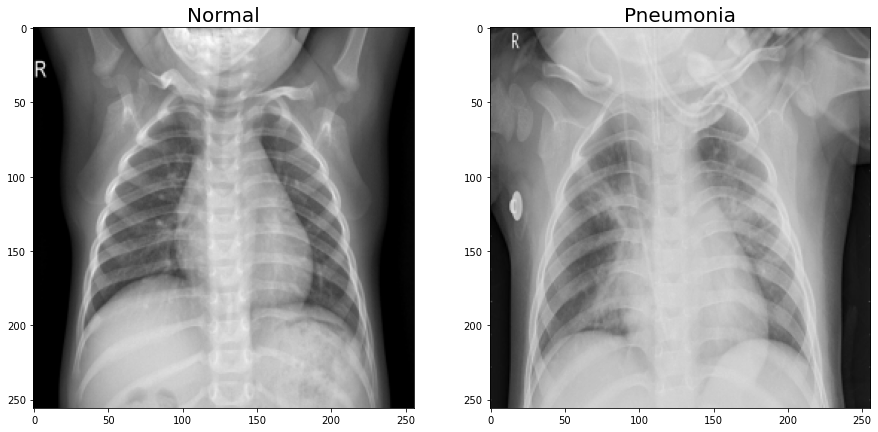

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,9))
axs[0].set_title("Normal", fontsize="20")
axs[0].imshow(x_raysKMeans[2].reshape(256,256), cmap=plt.get_cmap('gray'))
axs[1].set_title("Pneumonia", fontsize="20")
axs[1].imshow(x_raysKMeans[-2].reshape(256,256), cmap=plt.get_cmap('gray'))

fig.show()

From the images above, we can clearly see that lungs with pneumonia look more cloudy than healthy lungs. When observing the images, the cloudiness of the lungs are a common difference between normal and infected lungs.

In [9]:
#shuffle
np.random.shuffle(x_raysKMeans)
np.random.shuffle(x_raysPCA)

In [10]:
#Reshape array to 1D nparray
x_raysKMeans = x_raysKMeans.reshape(5216, -1)/255

In [11]:
#Reshape array to 1D nparray and take transpose to create column vectors
x_raysPCA = x_raysPCA.reshape(5216, -1)/255
x_raysPCA = x_raysPCA.T

## K-means:

Using K-means, we can attempt to find some underlying patterns for our images by assigning our images to certain clusters. We know that the dataset contains x-rays of both healthy and infected lungs and from the visualization, we can clearly see a difference in cloudiness. So we can train our model to try and identify this difference.

In [12]:
#Helper functions for KMeans
def calcSqDistances(X, Kmus):
    res = np.zeros((X.shape[0], Kmus.shape[0]))
    for i in range(X.shape[0]):
        for j in range(Kmus.shape[0]):
            res[i, j] = np.linalg.norm(X[i] - Kmus[j])
    return res

def determineRnk(sqDmat):
    Rnk = np.tile(0, (sqDmat.shape[0], sqDmat.shape[1]))
    for i in range(sqDmat.shape[0]):
        index = np.argmin(sqDmat[i])
        Rnk[i][index] = 1
    
    return Rnk

def recalcMus(X, Rnk):
    recalc = np.zeros((Rnk.shape[1], X.shape[1]))
    
    for i in range(Rnk.shape[1]):
        recalc[i,:] = np.sum((np.array([Rnk[:,i]]).T) * X, axis = 0)/(np.sum(Rnk[:,i], axis = 0))
    return recalc

In [13]:
def runKMeans(matrix, K):
    #load data file specified by fileString from Bishop book
    start = time.time()
    X = matrix

    #determine and store data set information
    N, D = X.shape

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
#         plotCurrent(X, Rnk, Kmus)
#         time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)





        #check to see if the cluster centers have converged.  If so, break.
        diff = np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1))))
        print(diff)
        if diff < 1e-6:
            print(iter)
            break

    # plotCurrent(X, Rnk, Kmus)
    end = time.time()
    print("Total time: {}".format(end - start))
    return Kmus

In [14]:
xray_kmeans = runKMeans(x_raysKMeans, 2)

12372.442665662355
3187.2056385918877
1504.3930459654164
653.213265086843
336.6225464171863
193.1409953107217
128.2713936381222
69.412426668745
41.941040958886184
26.682651728677687
28.19407528377603
28.383492670494743
21.796862982124466
16.565148296140695
18.128320264538882
10.335432993019612
6.3028463129195655
6.144175072234106
0.0
18
Total time: 71.56023859977722


## Results from K-Means:

We can try to cluster K-means with 2 clusters (normal and pneumonia) to determine if K-means with 2 clusters is enough.

Not all clusters have enough images
No more pictures in cluster 1
No more pictures in cluster 1
No more pictures in cluster 1
No more pictures in cluster 1
No more pictures in cluster 1


<ipython-input-15-3d32466373d7>:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


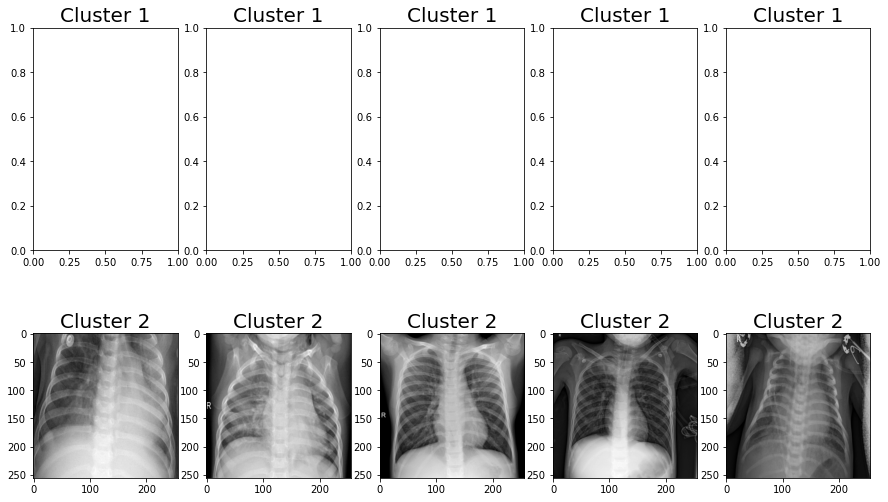

In [15]:
indices = []

for i in range(2):
  indices.append([])

i = 0
j = 0
while i < 5*2:
    if (j == xray_kmeans.shape[1]):
        print("Not all clusters have enough images")
        break
    val = max(xray_kmeans[:,j])
    pos = np.where(xray_kmeans[:,j] == val)[0][0]
    if (len(indices[pos]) != 5):
        indices[pos].append(j)
        i += 1
        
    j += 1

fig, axs = plt.subplots(2, 5, figsize=(15,9))
for col in range(5):
      try:
        axs[0][col].set_title("Cluster 1", fontsize="20")
        axs[0][col].imshow(x_raysKMeans[indices[0][col]].reshape(256,256), cmap=plt.get_cmap('gray'))
      except:
        print("No more pictures in cluster 1")

      try:
        axs[1][col].set_title("Cluster 2", fontsize="20")
        axs[1][col].imshow(x_raysKMeans[indices[1][col]].reshape(256,256), cmap=plt.get_cmap('gray'))
      except:
        print("No pictures in cluster 2")

fig.show()

In [16]:
print(xray_kmeans)

[[0.16432235 0.16936925 0.1895628  ... 0.06146962 0.06321931 0.07046931]
 [0.21677999 0.22662194 0.24557264 ... 0.07848309 0.07943078 0.08672934]]


From the results above, it doesn't seem like K-means with 2 clusters is enough to find any underlying patterns. Note that one of the clusters is empty which is odd. Lets try 4 clusters.

In [17]:
four_clusters = runKMeans(x_raysKMeans, 4)

18961.71020264646
3270.706048060408
2177.194413648744
1714.0203977137044
1213.517695649232
947.2743789511424
886.9459543712671
890.511001166562
871.0526628765848
863.0915088999009
774.6981909502463
653.9192881023632
599.7214728512241
459.34838869006455
374.23729225415656
284.28280980451507
192.94569359813107
137.39195161054047
71.17236662871437
71.6531930187798
94.12662159733465
52.97899092829335
45.65431245704369
44.191727598831456
41.409136272790434
19.069847142130577
9.894407604679923
10.114149591872467
9.994989201981388
0.0
29
Total time: 194.57852840423584


In [18]:
indices = []

for i in range(4):
  indices.append([])

i = 0
j = 0
while i < 5*4:
    if (j == xray_kmeans.shape[1]):
        print("Not all clusters have enough images")
        break
    val = max(four_clusters[:,j])
    pos = np.where(four_clusters[:,j] == val)[0][0]
    if (len(indices[pos]) != 5):
        indices[pos].append(j)
        i += 1
        
    j += 1

print(indices)

Not all clusters have enough images
[[36, 37, 38, 39, 40], [32479, 32480, 32481, 32736, 32737], [0, 1, 2, 3, 4], []]


One of the four clusters is also empty. We believe that this is likely due to a bad selection of cluster numbers K or because of noise in the data.

## PCA:


In [19]:
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort, lambd

#Helper function to normalize matrix

def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

#Helper function to plot skree plot of lambdas

def skree(lambd):
    plt.plot(np.arange(len(lambd)) + 1, lambd, 'ro-', linewidth = 2)
    plt.title("Scree Plot")
    plt.xlabel("Principal Component")
    plt.ylabel("Eigenvalue")
    return

#Helper function to return variance explained and cumulataive sum of variance

def explained_variance(eigen_values):

  #explains how much of the data each component describes 
    var_exp = [(i/sum(eigen_values))*100 for i in eigen_values]
  
  #cumsum of var_exp for easier visualization
    cumsum_var = np.cumsum(var_exp)

    return var_exp, cumsum_var

#Helper function to viewcolumn vectors

def viewcolumn(columnvector):
    plt.imshow(columnvector.reshape(
        [256, 256], order='F'), cmap=plt.get_cmap('gray'))
    plt.show()

#Helper function to retrive indice where threshold variance is explained
#e.g. returns i = 4 if first 5 components explain threshold variance

def indexfinder(cumsum, threshold):
    for i in range(len(cumsum)):
        if cumsum[i] >= threshold:
            return i

In [20]:
x_raysPCA.shape

(65536, 5216)

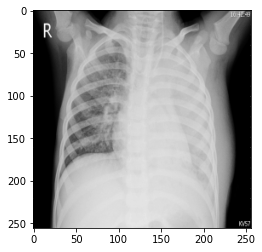

In [21]:
viewcolumn(x_raysPCA[:,0])

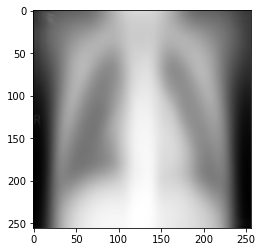

In [22]:
mean_xrays = np.mean(x_raysPCA, axis = 1)[:,None]
viewcolumn(mean_xrays)

In [23]:
A = (x_raysPCA - mean_xrays).real.astype(np.float32)
cov = np.divide(A.T@A, 5216)

In [24]:
eigvals, V = np.linalg.eig(cov)
Vsort, Dsort, lambd = eigsort(V, eigvals)

<ipython-input-19-b1edd943f5b5>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  Vsort[:,i] = V[:,index[i]]


In [25]:
U = A @ Vsort
U = normc(U)

C:\Users\wilso\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


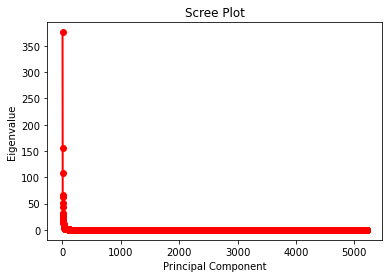

In [26]:
#Skree plot
#Elbow at near right angle, extreme drop off of variance explained by components 
#following elbow
skree(lambd)

In [27]:
exp, cumsum = explained_variance(eigvals)
cumsum

array([ 25.24716782+0.j,  35.67791557+0.j,  42.91349135+0.j, ...,
        99.99960072+0.j,  99.99980031+0.j, 100.        +0.j])

In [28]:
indexfinder(cumsum, 96)

647

In [29]:
reduced_U = U[:625]
x_rays_temp = x_raysPCA[:,:625] - mean_xrays

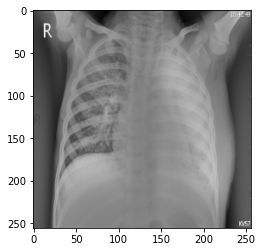

(65536, 625)

In [30]:
viewcolumn(x_rays_temp[:,0])
reduced_U.shape
x_rays_temp.shape

In [31]:
reduced_xrays = reduced_U.T @ x_rays_temp[:625]

In [32]:
zhat = U[:,:625] @ reduced_xrays[:625] + mean_xrays

In [33]:
#shape comparisons
reduced_xrays.shape, x_raysPCA.shape, zhat.shape

((5216, 625), (65536, 5216), (65536, 625))

## KMeans with PCA:

Before we saw that 2 clusters wasn't enough for K-Means. We can try again this time using PCA.

In [34]:
#KMeans on PCA reduced xrays, significantly faster
reduced_test = runKMeans(reduced_xrays, 2)

41.039872145338876
42.587499884088345
65.87288606149622
55.92824205035562
50.784744822807475
32.562919239021646
23.01515879109597
0.0
7
Total time: 1.454265832901001


In [35]:
print(reduced_test.shape)

(2, 625)


In [36]:
#Initialize cluster arrays for visualization
cluster1, cluster2 = [], []

In [37]:
#Retrieving image indices that are in cluster 1 and 2

i = 0
j = 0
while i < 20:
    if (reduced_test[:,j][0] < reduced_test[:,j][1]):
            cluster2.append(j)
            i += 1
    j += 1
j = 0
i = 0
while i < 20:
    if (reduced_test[:,j][0] > reduced_test[:,j][1]):
            cluster1.append(j)
            i += 1
    j += 1

In [38]:
#cluster1, cluster2

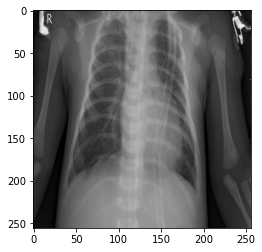

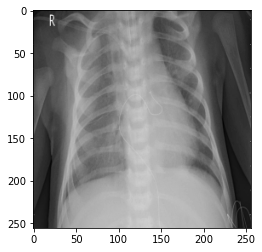

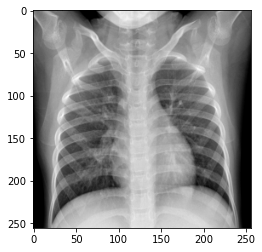

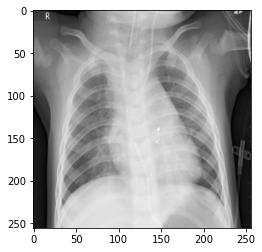

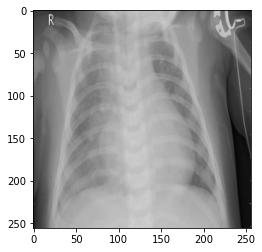

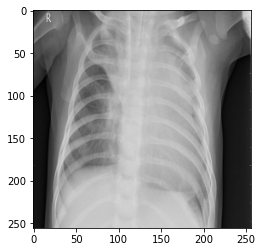

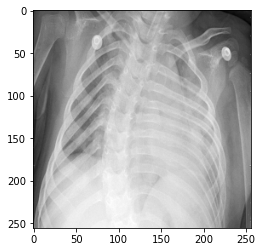

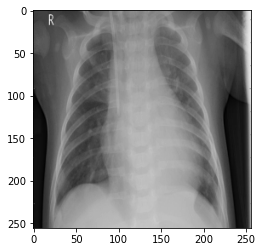

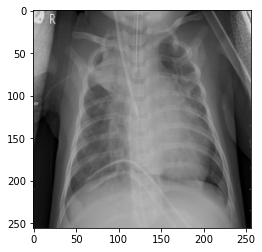

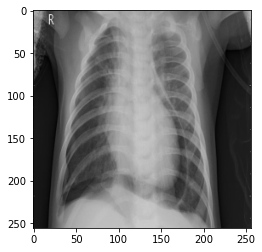

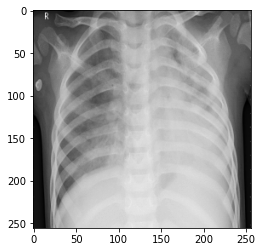

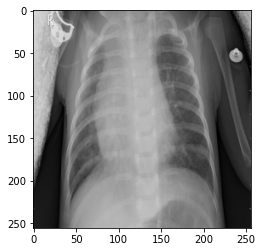

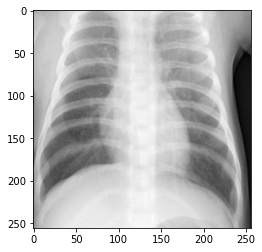

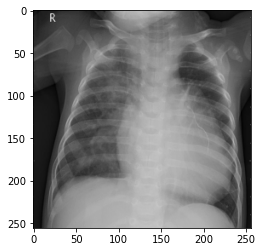

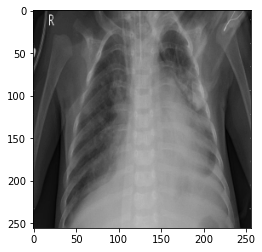

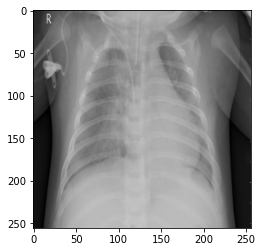

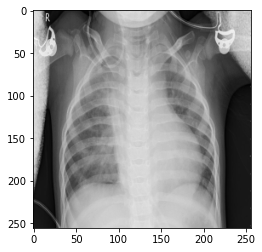

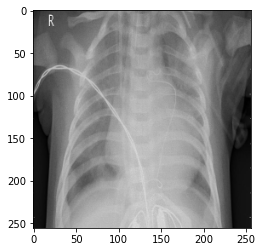

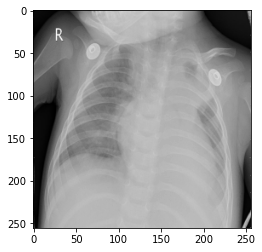

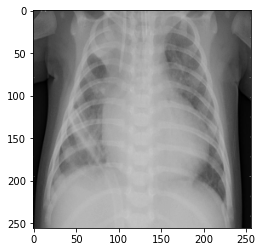

In [39]:
#visualizing cluster 1
for i in cluster1:
    viewcolumn(x_raysPCA[:,i])

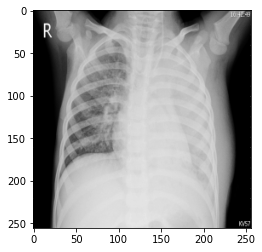

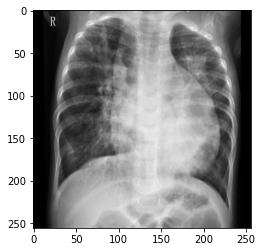

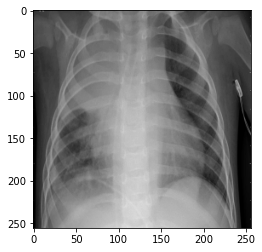

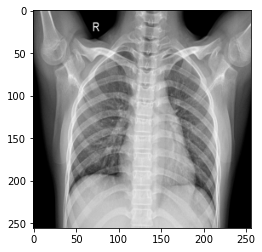

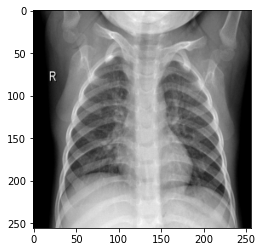

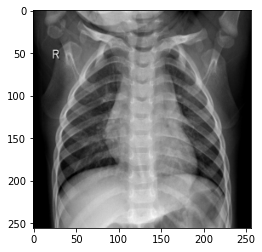

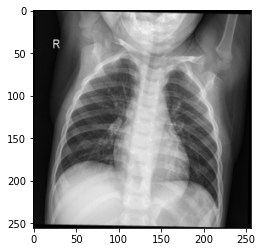

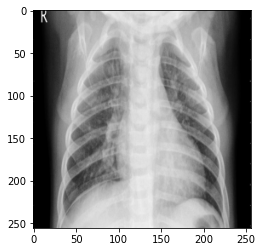

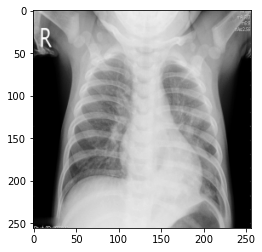

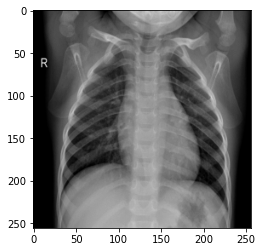

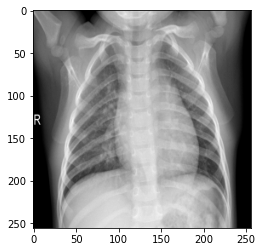

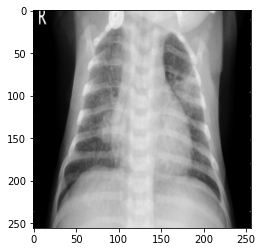

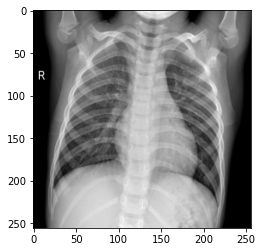

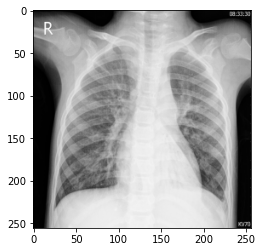

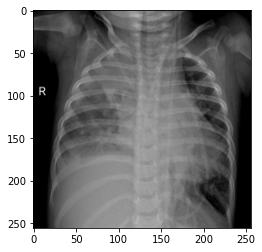

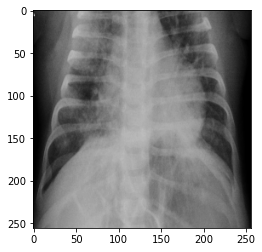

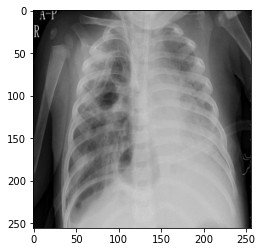

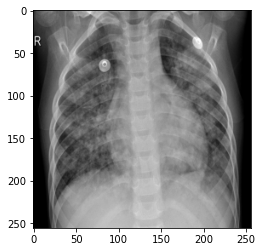

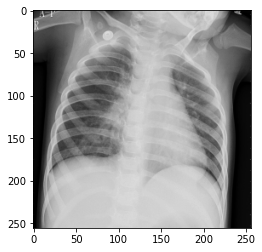

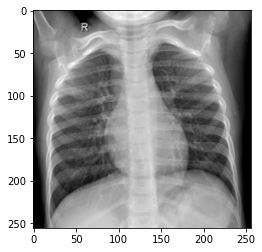

In [40]:
#Visualizing cluster 2
for i in cluster2:
    viewcolumn(x_raysPCA[:,i])

From the cells above, you can see that the images were actually clustered to 2 different clusters unlike K-means without PCA.

## Comparing Runtime for K-means w/ and w/o PCA

In [41]:
#Time test
runKMeans(x_raysKMeans[:625], 10)

53548.822670233174
9314.077743562904
6346.191021195591
4296.715467690566
3651.65551116309
3621.9543255571148
3022.3991684160164
2967.4601662695227
1620.1992792101012
1366.9833057770156
1500.3032211237635
1131.490470975308
168.30361551531814
0.0
13
Total time: 28.647340536117554


array([[0.11924665, 0.14788442, 0.21578947, ..., 0.00902993, 0.01037152,
        0.02125903],
       [0.17628819, 0.1873233 , 0.18978568, ..., 0.09439124, 0.10506156,
        0.11974464],
       [0.2025098 , 0.19581699, 0.19435294, ..., 0.10243137, 0.10718954,
        0.1183268 ],
       ...,
       [0.2550472 , 0.25381264, 0.26129267, ..., 0.16688453, 0.16499637,
        0.1761801 ],
       [0.09623991, 0.10163783, 0.10560554, ..., 0.00489043, 0.00535179,
        0.0083045 ],
       [0.18635621, 0.19493464, 0.21552288, ..., 0.05506536, 0.06053922,
        0.0744281 ]])

In [42]:
runKMeans(reduced_xrays, 10)

213.1901134461638
155.71879408403973
75.87802403495101
64.17940772653648
40.487340788519944
40.672401751022164
44.72408821230903
27.858288640768443
27.031502922451544
34.78241818641193
28.473075977879002
38.547042330769145
96.87278392305993
106.2128734882965
39.512227150981744
49.29032539633556
35.336850606859294
37.41574139229073
29.026356321187027
42.41300389432258
11.75835055999395
6.570423716371712
3.623387080279431
0.7772800766645174
0.24049217327261535
0.15250538715516773
0.3747579379358472
0.3957877587946823
0.3711988706653286
0.5559666113437782
0.40445626421108855
0.5082873012579204
0.38193922959136983
0.2827006161262135
0.2984889691975597
0.34817134909960074
0.09883117556242557
0.16905248823942184
0.17853010717110304
0.20667517659669954
0.210360015200249
0.20788131513124256
0.1662706684875906
0.14611003117709098
0.12751434065540207
0.08962814060672034
0.07702389001780785
0.30245187266691675
0.3255515030442923
0.1630661886202616
0.20969498624845
0.2089034590943466
0.20328287358

array([[ 0.02167121,  0.0224181 , -0.01800972, ...,  0.02247193,
        -0.00644068,  0.0224181 ],
       [-0.1972697 , -0.20676901,  0.06475287, ..., -0.13640351,
         0.09471612, -0.20676901],
       [ 0.53156515,  0.54928909,  0.03244794, ...,  0.16055572,
        -0.270693  ,  0.54928909],
       ...,
       [-0.02804302, -0.0283867 , -0.00359976, ..., -0.00739442,
         0.00952761, -0.0283867 ],
       [ 0.06237908,  0.06266947,  0.08887559, ..., -0.06593977,
        -0.05550604,  0.06266947],
       [ 0.19110855,  0.19783351,  0.03303859, ...,  0.06547927,
        -0.09976297,  0.19783351]])

So, not only was it able to cluster the images to 2 clusters, but it also (on average) runs faster.